In [1]:
import tensorflow as tf
import numpy as np
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]=""
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np

Using TensorFlow backend.


In [2]:
batch_size = 64  
epochs = 8
data_augmentation = True
num_classes = 10
n = 6
depth = 6 * n + 2

subtract_pixel_mean = True
version = 1

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

input_shape = x_train.shape[1:]

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean 
    x_test -= x_train_mean 

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [3]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [4]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))
    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

def resnet_v1(input_shape, depth = depth, num_classes=10):
   
    #if (depth - 2) % 6 != 0:
    #    raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)
    
    inputs = Input(shape=input_shape)
    
    x = resnet_layer(inputs=inputs)
    for stack in range(3):
        
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  
                strides = 2  
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0: 
                
                
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y]) 
            x = Activation('relu')(x)
        num_filters *= 2

    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [5]:
model = resnet_v1(input_shape=input_shape, depth= depth)

model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()













Learning rate:  0.001


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normali

In [6]:
lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [lr_reducer, lr_scheduler]

In [7]:
# 第一種設定
datagen = ImageDataGenerator(    
    featurewise_center=False,    
    samplewise_center=False,    
    featurewise_std_normalization=False,    
    samplewise_std_normalization=False,    
    zca_whitening=False,    
    zca_epsilon=1e-06,    
    rotation_range=0,    
    width_shift_range=0.1,    
    height_shift_range=0.1,    
    shear_range=0.,    
    zoom_range=0.,    
    channel_shift_range=0.,    
    fill_mode='nearest',    
    cval=0.,    
    horizontal_flip=True,    
    vertical_flip=False,    
    rescale=None,    
    preprocessing_function=None,    
    data_format=None,    
    validation_split=0.0)

datagen.fit(x_train)

In [8]:
# 第二種設定
augment_generator = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

In [ ]:
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=int(len(x_train)/batch_size),
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    workers=4,
                    callbacks=callbacks)

scores = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]



Epoch 1/8
Learning rate:  0.001
775/781 [============================>.] - ETA: 3s - loss: 0.4309 - acc: 0.9117

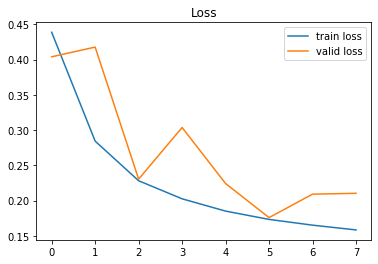

NameError: name 'train_acc' is not defined

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()